In [1]:
import pandas as pds
import numpy as np
import textdistance
import statsmodels.api as sm
import scipy
import math
import tqdm
import os
import seaborn as sns
from random import choices
from matplotlib import pyplot as plt
import scipy.interpolate as interpolate
import defs

In [9]:
name_DF = 'DF_N=4401_2023-01-16.csv'
DF = pds.read_csv(os.path.join('..', 'datasets', name_DF), delimiter = ',')
DF = DF[~DF.duplicated()] # delete duplicates
DF = DF.dropna() # delete NaN values
DF['was_assigned_female'] = DF['was_assigned_female'].astype('int32') # turn was_born_female into int type (once Nan values have been removed)
DF = DF.drop(['name', 'family_name'], axis=1)

# generate covariates
DF['X1'] = 2020 - DF['birth_year'] # age
DF['X2'] = np.random.normal(loc = 2.5, scale = 1, size = DF.shape[0])
DF['X3'] = np.random.normal(loc = 0, scale = 1, size = DF.shape[0])
DF['X4'] = np.random.normal(loc = 1, scale = 1, size = DF.shape[0])
DF['X5'] = np.random.normal(loc = 1, scale = 1, size = DF.shape[0])

# generate treatment
DF['treatment'] = np.random.binomial(n = 1, p = 1 / ( 1 + np.exp(0.1*DF.X1 -0.2*DF.X2 +0.3*DF.X3 -0.4*DF.X4 +0.5*DF.X5) )) # probability depending on covariates

# generate outcome
residual_errors = np.random.normal(size = DF.shape[0])
aaa = 5.5
bbb = 0.01
ccc = 0.08
ddd = 0.7

ate_on_DF = aaa * 2.5
DF['Y'] = - 10 + aaa*DF['treatment']*DF['X2'] + bbb*np.exp(DF['X4']) + ccc*DF['X3']*DF['X1'] + ddd*DF['X5'] 

# generate new categorical variables for linkage
DF['id1'] = np.random.choice(np.arange(10), size = DF.shape[0]).astype(int)
DF['id2'] = np.random.choice(np.arange(15), size = DF.shape[0]).astype(int)
DF['id3'] = np.random.choice(np.arange(5), size = DF.shape[0]).astype(int)

identifiers = {'was_assigned_female':'strict','country':'strict','birth_year':'strict','id1':'strict','id2':'strict','id3':'strict'} # 'family_name':'jaro-winkler',
covariates = ['X1','X2','X3','X4','X5']

nbr_in_common = 100
nbr_iter = 800
approx_integral = 50
a_sigma, b_sigma, a_sigma2, b_sigma2, a, b, alpha_pi, beta_pi = 1, 1, 1, 1, 1, 1, 1, 1
montecarlo_size_for_coverage = 105

methods = {'jaro-winkler':defs.jaro_winkler_similarity, 'levenshtein':defs.levenshtein_similarity, 'strict':defs.strict_equality, 'large':defs.large_equality}

dict_params_legend = {
    "unmatch":identifiers.keys(), 
    "match":identifiers.keys(), 
    "sigma_square":[f"$\sigma^2$"], 
    "betas":[ r"$\beta_0$", r"$\beta_1$", r"$\beta_2$", r"$\beta_3$", r"$\beta_4$", r"$\beta_5$", r"$\beta_6$", r"$\beta_7$" ], 
    "sigma2_square":[r"$\sigma_2^2$"], 
    "mu2":[r"$\mu_2$"], 
    "atel":["atel"]}

dict_params_title = {
    "unmatch":"unmatch", 
    "match":"match", 
    "sigma_square":r"$\sigma^2$", 
    "betas":r"$\beta$",
    "sigma2_square":r"$\sigma_2^2$", 
    "mu2":r"$\mu_2$", 
    "atel":"atel"}

In [3]:
common_records = DF.sample(n = nbr_in_common)

B = pds.concat([DF.sample(n = 250), common_records]).drop(['Y'], axis = 1)
B = B.reset_index(drop=True)

A = pds.concat([DF.sample(n = 430), common_records])[list(identifiers.keys())+['Y']]
A = A.reset_index(drop=True)

B.loc[np.random.choice(np.arange(B.shape[0]), size=5), 'id1'] = ''
A.loc[np.random.choice(np.arange(A.shape[0]), size=5), 'id3'] = ''
B.loc[np.random.choice(np.arange(B.shape[0]), size=5), 'id2'] = ''

B['propensity_score'] = defs.propensity_score(B, covariates, None, False)

ate_common_records = aaa * common_records['X2'].mean()

AB = B.merge(A, how='cross', suffixes=("_B", "_A")) 
AB["source_index_B"] = np.repeat(B.index, A.shape[0])
AB["source_index_A"] = np.tile(A.index, B.shape[0])

for linking_var in identifiers.keys():
    method = methods[identifiers[linking_var]]
    df = AB.filter(regex=linking_var)
    AB[linking_var+"_comparison"] = np.array([method(a, b) for a,b in zip(df.iloc[:,0], df.iloc[:,1])]).astype(int).reshape(-1,1)

comparison_vectors_only = AB.filter(regex="comparison")

true_linkage_z = -np.ones(B.shape[0])
true_linkage_z[B.iloc[-nbr_in_common:,:].index] = A.iloc[-nbr_in_common:,:].index

intercept = np.ones(AB.shape[0])
records_treatment =  np.array(AB.treatment)
records_propensity_score = np.array(AB.propensity_score)
interaction_term = records_treatment * records_propensity_score
records_covariates = np.array(AB[covariates])
XX = np.concatenate([intercept.reshape(-1,1), records_covariates, records_propensity_score.reshape(-1,1), interaction_term.reshape(-1,1)], axis=1)

records_treatment_miss =  1 - np.array(AB.treatment)
interaction_term_miss = records_treatment_miss * records_propensity_score
XX_miss = np.concatenate([intercept.reshape(-1,1), records_covariates, records_propensity_score.reshape(-1,1), interaction_term_miss.reshape(-1,1)], axis=1)

cartesian_product_AB = AB.copy(())

new_z = -np.ones(B.shape[0])
new_z[::2] = np.arange(len(new_z[::2]))

comparison_vectors = comparison_vectors_only.copy()
covariates = covariates.copy()
n_A = A.shape[0]
n_B = B.shape[0]
X = XX.copy()
X_miss = XX_miss.copy()

idx_match_A = new_z[new_z>=0]
idx_match_B = np.nonzero(new_z>=0)[0]
links = pds.MultiIndex.from_tuples(zip(idx_match_A,idx_match_B))
pairs = pds.MultiIndex.from_frame(cartesian_product_AB[["source_index_A", "source_index_B"]])
dict_empirical_count_linkage = {pair:0 for pair in pairs}
dict_params = {"unmatch":[], "match":[], "sigma_square":[], "betas":[], "sigma2_square":[], "mu2":[], "atel":[]}

Betas = scipy.stats.multivariate_normal.rvs(np.zeros(X.shape[1]), np.eye(X.shape[1]))
mu2 = scipy.stats.norm.rvs(0, 1)

dev = 0.25 * np.std(cartesian_product_AB.Y)
low_val = int(np.min(cartesian_product_AB.Y) - dev)
high_val = int(np.max(cartesian_product_AB.Y) + dev)
nbr_pts = int(high_val - low_val)

In [8]:
dict_coverage = {"mean":[], "bounds_tuple":[], "ate_common_records":[], "ate_mean":[], "ate_bounds_tuple":[]}

for _ in tqdm.tqdm(range(nbr_iter)):

    ### --  UPDATE THETA --> match, unmatch
    comparison_vectors_for_non_matches = comparison_vectors[~pairs.isin(links)]
    unmatch = scipy.stats.beta.rvs(comparison_vectors_for_non_matches.sum(axis=0) + a, (1-comparison_vectors_for_non_matches).sum(axis=0) + b)
    comparison_vectors_for_matches = comparison_vectors[pairs.isin(links)]
    match = scipy.stats.beta.rvs(comparison_vectors_for_matches.sum(axis=0) + a, (1-comparison_vectors_for_matches).sum(axis=0) + b)
    dict_params["unmatch"].append(unmatch)
    dict_params["match"].append(match)

    ### --  UPDATE COEF OUTCOME MODEL (MATCHES AND NON MATCHES) --> Betas --> mu2, sigma2_square --> outcome model distribution
    data_for_matches = cartesian_product_AB[pairs.isin(links)]
    outcome_for_matches =  np.array(data_for_matches.Y)
    intercept = np.ones(len(outcome_for_matches))
    treatment_for_matches =  np.array(data_for_matches.treatment)
    linked_records_propensity_score = np.array(data_for_matches.propensity_score)
    interaction_term = treatment_for_matches * linked_records_propensity_score
    linked_records_covariates = np.array(data_for_matches[covariates])
    K = np.concatenate([intercept.reshape(-1,1), linked_records_covariates, linked_records_propensity_score.reshape(-1,1), interaction_term.reshape(-1,1)], axis=1)
    n_AB = sum(new_z>=0)
    sigma_square = scipy.stats.invgamma.rvs(a_sigma + n_AB/2, loc=0, scale=np.linalg.norm(outcome_for_matches - K @ np.array(Betas))**2 / 2 + b_sigma) 
    Sigma_beta = np.linalg.inv( (K.T @ K)/sigma_square + np.eye(K.shape[1]) )
    mu_beta = Sigma_beta @ (K.T @ outcome_for_matches)/sigma_square
    Betas = scipy.stats.multivariate_normal.rvs(mu_beta, Sigma_beta)
    residuals = cartesian_product_AB.Y - X @ Betas.T
    estimated_variance = residuals.T @ residuals / (len(residuals) - (X.shape[1]+1))
    distr_linked_outcomes = scipy.stats.norm.pdf(residuals, 0, np.sqrt(estimated_variance))
    dict_params["sigma_square"].append(sigma_square)
    dict_params["betas"].append(Betas)

    data_for_non_matches = A[~A.index.isin(idx_match_A)]
    outcome_for_non_matches =  np.array(data_for_non_matches.Y)
    sigma2_square = scipy.stats.invgamma.rvs(a_sigma2 + (n_A - n_AB)/2, loc=0, scale=b_sigma2 + sum((outcome_for_non_matches - mu2)**2)/2) 
    sigma_mu2_square = 1 / ((n_A - n_AB)/sigma2_square + 1)
    m_mu2 = sigma_mu2_square * ((outcome_for_non_matches).sum() / sigma2_square)
    mu2 = scipy.stats.norm.rvs(m_mu2, np.sqrt(sigma_mu2_square))
    distr_non_linked_outcomes = scipy.stats.norm.pdf(cartesian_product_AB.Y, mu2, np.sqrt(sigma2_square))
    dict_params["sigma2_square"].append(sigma2_square)
    dict_params["mu2"].append(mu2)
    
    ### --  UPDATE PROBABILITIES
    w1 = ( np.multiply( comparison_vectors, np.log(match/unmatch) ) + np.multiply( 1-comparison_vectors, np.log((1-match)/(1-unmatch)) ) ).sum(axis=1)
    w2 = np.log(distr_linked_outcomes / distr_non_linked_outcomes)
    probabilities = np.array(np.exp(w1+w2))
    probabilities = probabilities.reshape(n_B, n_A)
    
    for j in range(n_B):
        n_AB_ = (np.delete(new_z, j)>=0).sum()
        proba_for_unmatch = (n_A - n_AB_) * (n_B - n_AB_ - 1 + beta_pi) / (n_AB_ + alpha_pi)
        not_possible_values = list( set(np.delete(new_z, j).astype(int)) - set([-1]) )
        proba = probabilities[j,:].copy()
        proba[not_possible_values]  = 0
        proba = np.append(proba, proba_for_unmatch)
        possible_values = np.arange(n_A)
        possible_values = np.append(possible_values, -1)
        val = choices(possible_values, weights = proba)[0]
        new_z[j] = val

    ### ATEL
    y_miss_new = np.random.uniform( low_val, high_val, size = (data_for_matches.shape[0], nbr_pts))
    X_miss_new = X_miss[pairs.isin(links)]
    Betas_miss_new = scipy.stats.multivariate_normal.rvs(mu_beta, Sigma_beta, size=(nbr_pts, approx_integral))
    y_miss_new = np.repeat(y_miss_new[:, np.newaxis, :], approx_integral, axis=1)
    ITS = np.mean( y_miss_new - ( Betas_miss_new @ X_miss_new.T ).T, axis = 1)
    missing_outcomes_new = np.array([ defs.inverse_transform_sampling(ITS[indiv], len(ITS[indiv])) for indiv in range(ITS.shape[0]) ])
    new_Y0 = (data_for_matches.treatment==0) * data_for_matches.Y + (data_for_matches.treatment==1) * missing_outcomes_new.flatten()
    new_Y1 = (data_for_matches.treatment==1) * data_for_matches.Y + (data_for_matches.treatment==0) * missing_outcomes_new.flatten()
    new_atel = np.mean(new_Y1 - new_Y0)
    dict_params["atel"].append(new_atel)

    ### _ UPDATE INDICES FOR MATCHES
    idx_match_A = new_z[new_z>=0]
    idx_match_B = np.nonzero(new_z>=0)[0]
    links = pds.MultiIndex.from_tuples(zip(idx_match_A,idx_match_B))

    for link in links:
        dict_empirical_count_linkage[link] += 1

v = np.array(list(dict_empirical_count_linkage.values())) / nbr_iter
k = np.array(list(dict_empirical_count_linkage.keys()))

nbr_bins = 10 * int( np.max(dict_params["atel"]) - np.min(dict_params["atel"]) )
ate_estimator = np.array([ defs.inverse_transform_sampling(dict_params["atel"], nbr_bins) for _ in range(montecarlo_size_for_coverage) ])
lower_bound, upper_bound = np.quantile(ate_estimator, [0.025, 0.975])
mean = np.mean(ate_estimator)

dict_coverage["mean"].append(mean)
dict_coverage["bounds_tuple"].append((lower_bound, upper_bound)) 
dict_coverage["ate_common_records"].append(ate_common_records)
dict_coverage["ate_mean"].append(mean - ate_common_records)
dict_coverage["ate_bounds_tuple"].append((lower_bound - ate_common_records, upper_bound - ate_common_records))

100%|██████████| 800/800 [01:51<00:00,  7.18it/s]


NameError: name 'montecarlo_size_for_coverage' is not defined

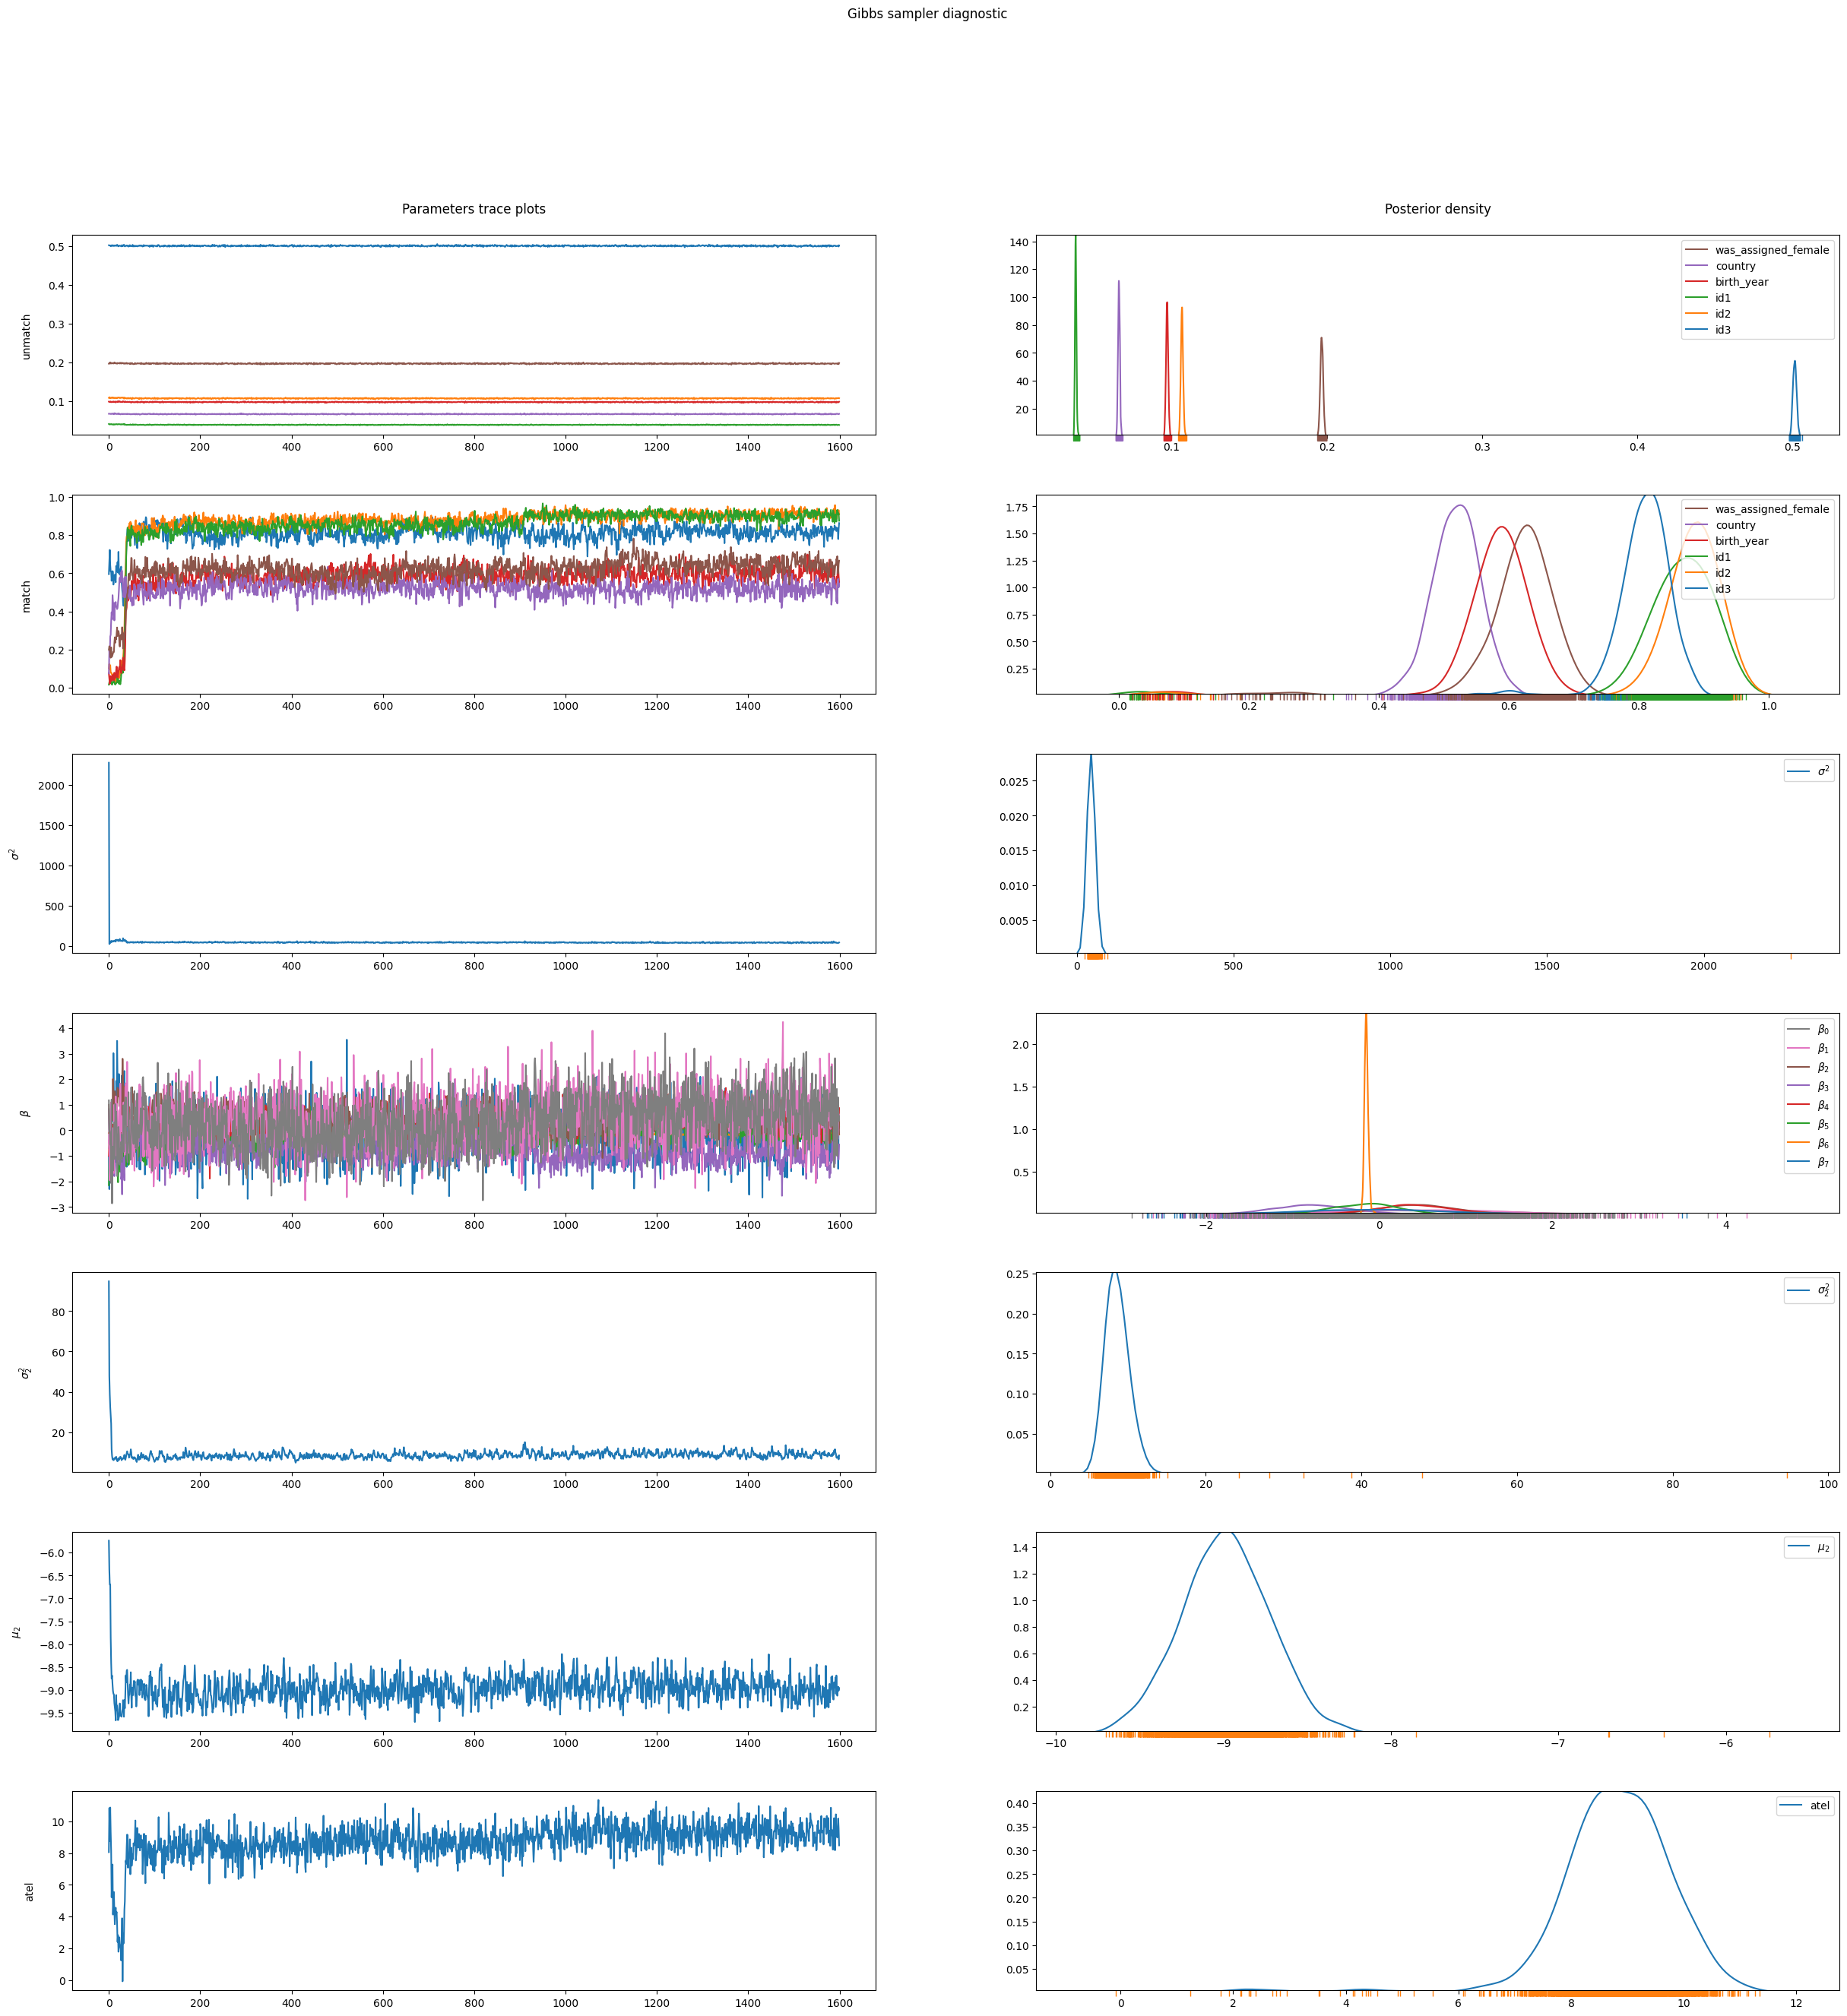

In [11]:
plt.figure(figsize = (30, 30))
plt.subplots_adjust(hspace=0.3)
plt.suptitle("Gibbs sampler diagnostic")
i=0
for n, param in enumerate(dict_params.keys()):
    i+=1
    ax1 = plt.subplot(7, 2, n + i) # row, column, number on which current drawing
    ax1.plot(dict_params[param])
    if n==0:
        ax1.set_title("Parameters trace plots\n")
    ax1.set_xlabel("")
    ax1.set_ylabel(f"{dict_params_title[param]}\n")
    j=i+1
    ax2 = plt.subplot(7, 2, n + j) 
    sns.kdeplot(data=np.array(dict_params[param]), ax=ax2, legend=None)
    sns.rugplot(data=np.array(dict_params[param]), ax=ax2, legend=None, height=-.03, clip_on=False)
    if n==0:
        ax2.set_title("Posterior density\n")
    ax2.legend(dict_params_legend[param], loc='upper right')
    ax2.set_xlabel("")
    ax2.set_ylabel("")
plt.savefig(os.path.join('img', f"gibbs_sampler_diagnostic.pdf"), format="pdf", bbox_inches="tight")
plt.show()

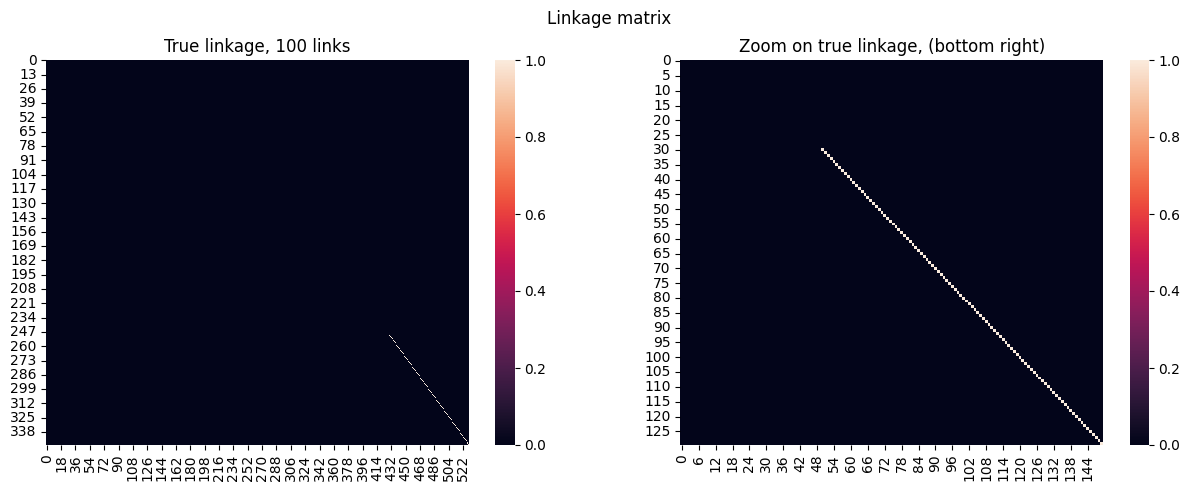

In [12]:
plt.figure(figsize = (15, 5))
plt.suptitle("Linkage matrix")
z_linkage_vector = true_linkage_z.copy()
idx_in_A_links = z_linkage_vector[z_linkage_vector>=0]
idx_in_B_links = np.nonzero(z_linkage_vector>=0)[0]
linkage_matrix = np.zeros((B.shape[0], A.shape[0]))
for link in range(len(idx_in_A_links)):
    linkage_matrix[int(idx_in_B_links[link]), int(idx_in_A_links[link])] = 1
ax1 = plt.subplot(1, 2, 1)
sns.heatmap(linkage_matrix, ax=ax1)
ax1.set_title(f"True linkage, {(linkage_matrix==1).sum()} links")
ax2 = plt.subplot(1, 2, 2)
sns.heatmap(linkage_matrix[220:, 380:], ax=ax2)
ax2.set_title(f"Zoom on true linkage, (bottom right)")
plt.savefig(os.path.join('img', f"true_linkage_{(linkage_matrix==1).sum()}links.pdf"), format="pdf", bbox_inches="tight")
plt.show()

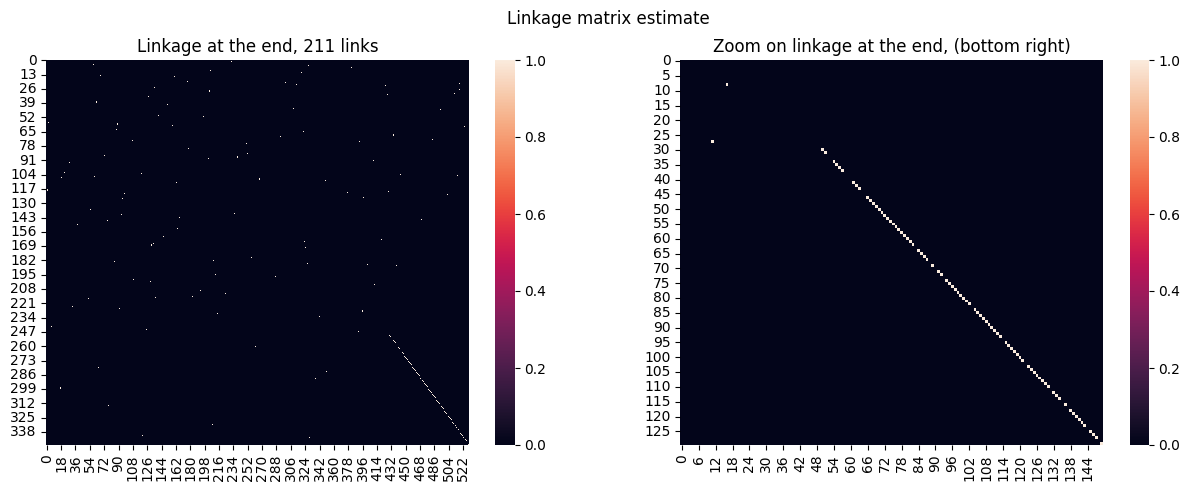

In [13]:
plt.figure(figsize = (15, 5))
plt.suptitle("Linkage matrix estimate")
best = k[v>=0.9] # require to fix a number of link to make: k[np.argpartition(v, -100)[-100:]] # require to have high confidence enough for some links k[v>=0.9]
idx_A = best[:,0]
idx_B = best[:,1]
linkage_matrix = np.zeros((B.shape[0], A.shape[0]))
for link in range(len(idx_A)):
    A_idx = idx_A[link]
    B_idx = idx_B[link]
    linkage_matrix[B_idx, A_idx] = 1
ax1 = plt.subplot(1, 2, 1)
sns.heatmap(linkage_matrix, ax=ax1)
ax1.set_title(f"\nLinkage at the end, {(linkage_matrix==1).sum()} links")
ax2 = plt.subplot(1, 2, 2)
sns.heatmap(linkage_matrix[220:, 380:], ax=ax2)
ax2.set_title(f"\nZoom on linkage at the end, (bottom right)")
plt.savefig(os.path.join('img', f"linkage_at_end_{(linkage_matrix==1).sum()}links.pdf"), format="pdf", bbox_inches="tight")
plt.show()

Text(0.5, 1.0, '95% credible interval for the ATE')

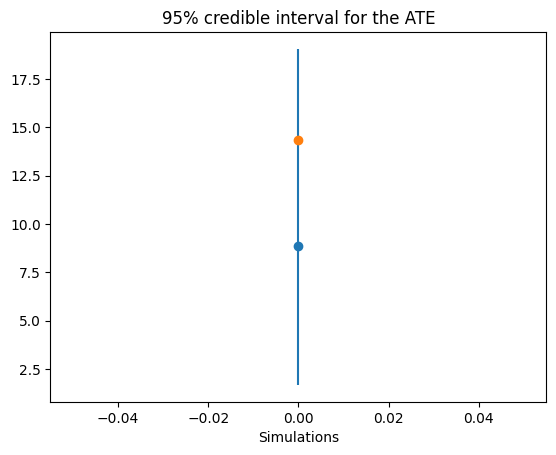

In [14]:
nbr_simulations = 1

plt.errorbar(np.arange(nbr_simulations), dict_coverage["mean"], yerr=np.array(dict_coverage["bounds_tuple"]).T, fmt='o')
plt.plot(np.arange(nbr_simulations), dict_coverage["ate_common_records"], 'o')
plt.xlabel("Simulations")
plt.title("95% credible interval for the ATE")

Text(0.5, 1.0, '95% credible interval for the ATE centered around the ate_common_records')

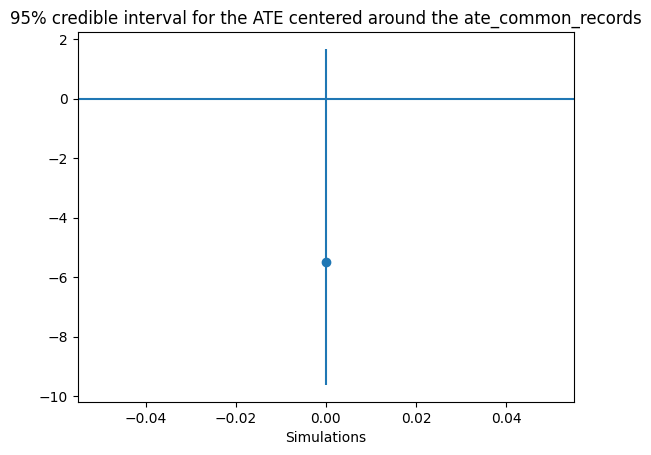

In [15]:
plt.errorbar(np.arange(nbr_simulations), dict_coverage["ate_mean"], yerr=np.array(dict_coverage["ate_bounds_tuple"]).T, fmt='o')
plt.axhline(0)
plt.xlabel("Simulations")
plt.title("95% credible interval for the ATE centered around the ate_common_records")